<a href="https://colab.research.google.com/github/arun4589/ML/blob/main/transfer_learning_1_(without_data_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# in this tut we will learn about transfer learning , transfer learning is the process in which we use a pretrained model by modifing its some of conv layer or fully connected
# layer it will reduce time and also increase its accuracy
# we can use transfer learning in two ways 1. feature extractiion(modifing only FC layers) 2. fine tuning(modifing FC and some of conv layers)
# in this series of tut we also be using data augmentation (used for reducing overfitting) data augmentation can also be used if we have less data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:09<00:00, 83.4MB/s]
100% 1.06G/1.06G [00:09<00:00, 114MB/s] 


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Dropout
from keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

In [6]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)
valid_ds=keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image,label

train_ds=train_ds.map(process)
valid_ds=valid_ds.map(process)
# normalizing all images data between 0 to 1

In [8]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
# include_top=false means we only taking conv layers not FC layers(top)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
conv_base.trainable = False
# due to this code we are just freezing the conv layer by making its parameters nontrainable

In [10]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
history =model.fit(train_ds,epochs=10,validation_data=valid_ds,)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.8510 - loss: 0.3689 - val_accuracy: 0.9090 - val_loss: 0.2147
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 102ms/step - accuracy: 0.9161 - loss: 0.2007 - val_accuracy: 0.9106 - val_loss: 0.2021
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step - accuracy: 0.9322 - loss: 0.1633 - val_accuracy: 0.9132 - val_loss: 0.2046
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.9329 - loss: 0.1534 - val_accuracy: 0.9128 - val_loss: 0.2265
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9541 - loss: 0.1175 - val_accuracy: 0.9108 - val_loss: 0.2324
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9617 - loss: 0.0979 - val_accuracy: 0.9046 - val_loss: 0.2845
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9772 - loss: 0.0640 - val_accuracy: 0.9080 - val_loss: 0.2940
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9786 - loss: 0.0583 

Text(0.5, 0, 'epoch')

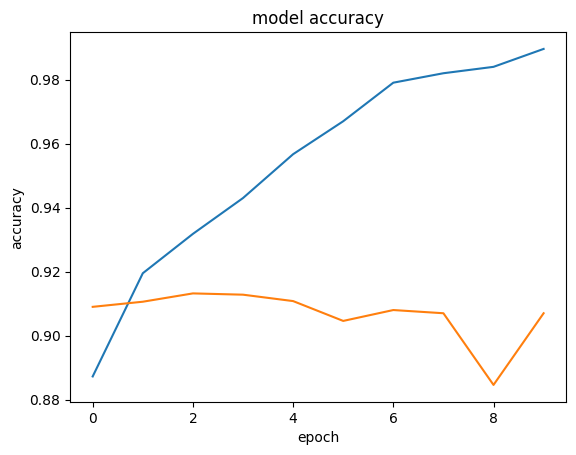

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

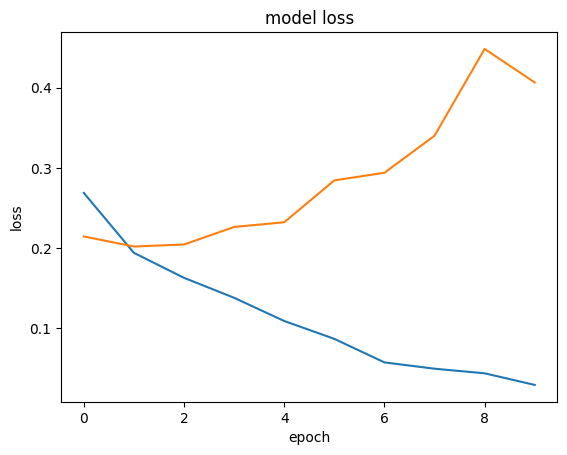

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [16]:
# these graph tells that there is much overfitting so we will try to reduce overfitting by  data augmentation in nxt tut